In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

"""
I am develoer who works very well with scripts so most of the results are at the functions in the end.
Please skip to those directly for results or continue from here for a semi-full tour of how my brain approached this problem.
"""

'\nI am develoer who works very well with scripts so most of the results are at the functions in the end.\nPlease skip to those directly for results or continue from here for a semi-full tour of how my brain approached this problem.\n'

# Airbnb Price Prediction Model

## Approach Overview
- Built hybrid model combining Gradient Boosting and Random Forest regressors
- Focused on robust feature engineering and data cleaning
- Implemented comprehensive preprocessing pipeline for both numeric and categorical features

## Key Challenges & Solutions

### Data Preprocessing
- **Missing Values**: Implemented strategic filling using median/mode based on feature type
- **Price Outliers**: Removed top 1% to improve model stability
- **Feature Scaling**: Used PowerTransformer for non-normal distributions
- **Log Transformation**: Applied to price values to handle skewness

### Feature Engineering Decisions
- Created derived features like total_rooms and space_efficiency
- Added geographic features using Haversine distance
- Developed interaction terms between reviews and ratings

### Model Selection Journey
1. **Initial Attempts**
   - Single model approaches showed limited performance
   - KMeans clustering for market segmentation proved ineffective
   - Neural networks overfit despite regularization

2. **Final Solution**
   - Hybrid ensemble of GB and RF provided best balance
   - Achieved 95.2% accuracy with balanced error metrics
   - MAE of $2.53 indicates strong practical utility

## Performance Highlights
- RMSE: $8.12
- MAE: $2.53
- R² Score: 0.952

## Key Learnings
- Feature engineering more impactful than model complexity
- Geographic features crucial for price prediction
- Ensemble methods outperformed single models
- Simple, interpretable features better than complex transformations

In [2]:
def clean_property_data(df):
    """
    Cleans and preprocesses property-specific features:
    - Selects relevant columns
    - Handles missing values for numeric and categorical fields
    - Returns cleaned DataFrame with standardized features
    """
    keep_cols = ['propertyType', 'personCapacity', 'listingLat', 'listingLng', 
                 'roomType', 'visibleReviewCount', 'valueRating', 'locationRating', 
                 'communicationRating', 'checkinRating', 'accuracyRating']
    
    cleaned = df[keep_cols].copy()
    cleaned['personCapacity'] = cleaned['personCapacity'].fillna(cleaned['personCapacity'].median())
    cleaned['visibleReviewCount'] = cleaned['visibleReviewCount'].fillna(0)
    
    rating_cols = [col for col in cleaned.columns if 'Rating' in col]
    for col in rating_cols:
        cleaned[col] = cleaned[col].fillna(cleaned[col].median())
    
    cleaned['propertyType'] = cleaned['propertyType'].fillna(cleaned['propertyType'].mode()[0])
    cleaned['roomType'] = cleaned['roomType'].fillna(cleaned['roomType'].mode()[0])
    
    return cleaned

def clean_reviews(df):
    """
    Processes review data:
    - Extracts essential review features
    - Converts ratings to numeric
    - Handles missing values
    """
    keep_cols = ['property_id', 'rating', 'comments']
    cleaned = df[keep_cols].copy()
    cleaned['rating'] = pd.to_numeric(cleaned['rating'], errors='coerce')
    cleaned['rating'] = cleaned['rating'].fillna(cleaned['rating'].median())
    cleaned['comments'] = cleaned['comments'].fillna('')
    return cleaned

def clean_place_data(df):
    """
    Cleans place-specific data:
    - Processes core property metrics
    - Handles currency and numeric conversions
    - Fills missing values appropriately
    """
    keep_cols = ['avgRating', 'bathrooms', 'bedrooms', 'beds', 'reviewsCount', 'price']
    cleaned = df[keep_cols].copy()
    
    cleaned['price'] = cleaned['price'].str.replace('\xa0', ' ').str.replace('$', '').str.replace(' CAD', '')
    cleaned['price'] = pd.to_numeric(cleaned['price'], errors='coerce')
    
    cleaned['avgRating'] = cleaned['avgRating'].fillna(cleaned['avgRating'].median())
    cleaned['reviewsCount'] = cleaned['reviewsCount'].fillna(0)
    
    for col in ['bathrooms', 'bedrooms', 'beds']:
        cleaned[col] = cleaned[col].fillna(cleaned[col].median())
    
    return cleaned

In [3]:
def load_data():
    """
    Loads and combines all data sources:
    - Reads CSV files
    - Applies cleaning functions
    - Merges datasets
    """
    detailed_property = pd.read_csv('/kaggle/input/tensorlabs-2025-internships/Detailed_Property.csv')
    property_reviews = pd.read_csv('/kaggle/input/tensorlabs-2025-internships/Property_Reviews.csv')
    property_by_place = pd.read_csv('/kaggle/input/tensorlabs-2025-internships/property_by_place.csv')
    
    property_clean = clean_property_data(detailed_property)
    place_clean = clean_place_data(property_by_place)
    reviews_clean = clean_reviews(property_reviews)
    
    df = pd.merge(property_clean, place_clean, left_index=True, right_index=True, how='inner')
    return df

In [4]:
def enhance_features(df):
    """
    Creates engineered features:
    - Calculates derived metrics
    - Adds geographic features
    - Computes efficiency ratios
    """
    df_enhanced = df.copy()
    
    df_enhanced['total_rooms'] = df_enhanced['bedrooms'] + df_enhanced['bathrooms']
    df_enhanced['reviews_rating_interaction'] = df_enhanced['visibleReviewCount'] * df_enhanced['avgRating']
    df_enhanced['price_per_bedroom'] = df_enhanced['price'] / (df_enhanced['bedrooms'] + 1)
    df_enhanced['space_efficiency'] = df_enhanced['beds'] / (df_enhanced['bedrooms'] + 1)
    df_enhanced['bathroom_ratio'] = df_enhanced['bathrooms'] / df_enhanced['personCapacity']
    
    def haversine_distance(lat, lng, center_lat=51.0447, center_lng=-114.0719):
        R = 6371
        lat, lng = np.radians([lat, lng])
        center_lat, center_lng = np.radians([center_lat, center_lng])
        dlat = lat - center_lat
        dlng = lng - center_lng
        a = np.sin(dlat/2)**2 + np.cos(lat) * np.cos(center_lat) * np.sin(dlng/2)**2
        return 2 * R * np.arcsin(np.sqrt(a))

    df_enhanced['distance_to_center'] = df_enhanced.apply(
        lambda row: haversine_distance(row['listingLat'], row['listingLng']), 
        axis=1
    )
    
    return df_enhanced

In [5]:
def prepare_data(df):
    """
    Prepares data for modeling:
    - Applies feature engineering
    - Handles outliers
    - Sets up preprocessing pipeline
    - Splits features and target
    """
    df_clean = enhance_features(df)
    
    df_clean = df_clean[(df_clean['price'] > 0) & 
                        (df_clean['price'] <= df_clean['price'].quantile(0.99))]
    
    df_clean['price'] = np.log1p(df_clean['price'])
    
    numeric_features = [
        'bathrooms', 'bedrooms', 'beds', 'personCapacity',
        'visibleReviewCount', 'reviewsCount', 'avgRating',
        'valueRating', 'locationRating', 'communicationRating',
        'checkinRating', 'accuracyRating', 'total_rooms',
        'reviews_rating_interaction', 'price_per_bedroom',
        'space_efficiency', 'bathroom_ratio', 'distance_to_center'
    ]
    
    categorical_features = ['propertyType', 'roomType']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('power', PowerTransformer(standardize=True))
            ]), numeric_features),
            ('cat', OneHotEncoder(sparse_output=False), categorical_features)
        ]
    )
    
    X = df_clean[numeric_features + categorical_features]
    y = df_clean['price']
    
    return X, y, preprocessor, numeric_features, categorical_features

In [6]:
def train_hybrid_model(X, y, preprocessor):
    """
    Trains ensemble of models:
    - Splits data
    - Trains GB and RF models
    - Combines predictions
    - Calculates performance metrics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    gb_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            min_samples_split=4,
            min_samples_leaf=3,
            subsample=0.85,
            loss='huber',
            random_state=42
        ))
    ])
    
    rf_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=500,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=4,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    gb_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    
    gb_pred = gb_model.predict(X_test)
    rf_pred = rf_model.predict(X_test)
    y_pred = (gb_pred + rf_pred) / 2
    
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    return {
        'gb_model': gb_model,
        'rf_model': rf_model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'rmse': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
            'mae': np.abs(y_test_orig - y_pred_orig).mean(),
            'r2': r2_score(y_test_orig, y_pred_orig)
        }
    }

In [7]:
def plot_model_insights(results, preprocessor, numeric_features, categorical_features):
    """
    Creates visualization dashboard:
    - Actual vs predicted plot
    - Feature importance analysis
    - Price distribution
    - Residuals analysis
    """
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 12))
    
    # Get predictions
    gb_pred = results['gb_model'].predict(results['X_test'])
    rf_pred = results['rf_model'].predict(results['X_test'])
    ensemble_pred = (gb_pred + rf_pred) / 2
    
    y_test_orig = np.expm1(results['y_test'])
    y_pred_orig = np.expm1(ensemble_pred)
    
    # 1. Actual vs Predicted Plot
    plt.subplot(2, 2, 1)
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], 
             [y_test_orig.min(), y_test_orig.max()], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title('Actual vs Predicted Prices\nHybrid Model Performance')
    plt.legend()
    
    # 2. Feature Importance
    plt.subplot(2, 2, 2)
    feature_names = (numeric_features + 
                    preprocessor.named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    gb_importance = results['gb_model'].named_steps['regressor'].feature_importances_
    rf_importance = results['rf_model'].named_steps['regressor'].feature_importances_
    
    avg_importance = (gb_importance + rf_importance) / 2
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_importance
    }).sort_values('importance', ascending=True)
    
    plt.barh(range(10), importance_df['importance'][-10:])
    plt.yticks(range(10), importance_df['feature'][-10:])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features\nAveraged Across Both Models')
    
    # 3. Price Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(y_test_orig, bins=50, kde=True)
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    plt.title('Distribution of Actual Prices')
    
    # 4. Residuals Analysis
    plt.subplot(2, 2, 4)
    residuals = y_test_orig - y_pred_orig
    sns.scatterplot(x=y_pred_orig, y=residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals ($)')
    plt.title('Residuals Analysis')
    
    plt.tight_layout()
    return fig

In [8]:
def create_model_report(results):
    """
    Generates performance report:
    - Calculates key metrics
    - Formats results
    - Provides analysis summary
    """
    return f"""
    Hybrid Model Performance Report
    =============================
    
    Model Metrics:
    - RMSE: ${results['metrics']['rmse']:.2f}
    - MAE: ${results['metrics']['mae']:.2f}
    - R² Score: {results['metrics']['r2']:.3f}
    
    Analysis:
    - Average prediction error (RMSE): ${results['metrics']['rmse']:.2f}
    - Typical price deviation (MAE): ${results['metrics']['mae']:.2f}
    - Model explains {results['metrics']['r2']*100:.1f}% of price variation
    """

In [9]:
def analyze_listings_optimization(df, results, top_n=5):
    """
    Analyzes listings for revenue optimization opportunities
    """
    df_analysis = df.copy()
    
    # Calculate key metrics
    df_analysis['price_diff'] = np.abs(np.expm1(results['y_pred']) - np.expm1(results['y_test']))
    df_analysis['review_ratio'] = df_analysis['visibleReviewCount'] / df_analysis['reviewsCount'].median()
    df_analysis['room_efficiency'] = df_analysis['beds'] / df_analysis['bedrooms'].clip(lower=1)
    df_analysis['rating_gap'] = 5.0 - df_analysis['avgRating'].clip(upper=5.0)
    
    # Calculate potential revenue impact
    df_analysis['yearly_revenue'] = df_analysis['price'] * 365 * (df_analysis['visibleReviewCount'] / df_analysis['reviewsCount'].max())
    df_analysis['revenue_potential'] = df_analysis['yearly_revenue'] * (1 + df_analysis['rating_gap'] * 0.1)
    df_analysis['potential_gain'] = df_analysis['revenue_potential'] - df_analysis['yearly_revenue']
    
    # Score based on improvement potential
    df_analysis['opportunity_score'] = (
        df_analysis['price_diff'] * 0.3 +
        df_analysis['rating_gap'] * 0.3 +
        df_analysis['potential_gain'] * 0.4
    )
    
    # Get top opportunities
    opportunities = df_analysis.nlargest(top_n, 'opportunity_score')
    
    print(f"\n{'='*60}")
    print("High-Impact Optimization Opportunities")
    print(f"{'='*60}")
    
    for idx, row in opportunities.iterrows():
        print(f"\nListing ID: {idx}")
        print(f"Current Price: ${row['price']:.2f}")
        print(f"Property Type: {row['propertyType']}")
        
        print("\nOptimization Opportunities:")
        
        # Price optimization
        if row['price_diff'] > results['metrics']['mae']:
            suggested_price = row['price'] * (1 + (results['metrics']['mae'] / 100))
            print(f"1. Price Adjustment:")
            print(f"   → Suggested price: ${suggested_price:.2f}")
            print(f"   → Potential yearly impact: ${row['price_diff'] * 365:.2f}")
        
        # Rating optimization
        if row['rating_gap'] > 0.2:
            print(f"2. Rating Improvement:")
            print(f"   → Current rating: {row['avgRating']:.1f}/5.0")
            print(f"   → Focus areas: {', '.join(get_low_ratings(row))}")
        
        # Efficiency optimization
        if row['room_efficiency'] < df_analysis['room_efficiency'].median():
            print("3. Space Optimization:")
            print(f"   → Current beds/room: {row['room_efficiency']:.1f}")
            print(f"   → Recommended: {df_analysis['room_efficiency'].median():.1f}")
        
        print(f"\nEstimated Annual Revenue Impact: ${row['potential_gain']:.2f}")
        print("-" * 60)

def get_low_ratings(row):
    """Helper function to identify areas needing improvement"""
    ratings = {
        'Value': row['valueRating'],
        'Location': row['locationRating'],
        'Communication': row['communicationRating'],
        'Checkin': row['checkinRating'],
        'Accuracy': row['accuracyRating']
    }
    return [k for k, v in ratings.items() if v < 4.5]

<ipython-input-7-d07fc576310e>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



    Hybrid Model Performance Report
    
    Model Metrics:
    - RMSE: $8.12
    - MAE: $2.53
    - R² Score: 0.952
    
    Analysis:
    - Average prediction error (RMSE): $8.12
    - Typical price deviation (MAE): $2.53
    - Model explains 95.2% of price variation
    

High-Impact Optimization Opportunities

Listing ID: 211
Current Price: $98.00
Property Type: Entire condo

Optimization Opportunities:
2. Rating Improvement:
   → Current rating: 4.8/5.0
   → Focus areas: 

Estimated Annual Revenue Impact: $263.37
------------------------------------------------------------

Listing ID: 328
Current Price: $63.00
Property Type: Entire cottage

Optimization Opportunities:
2. Rating Improvement:
   → Current rating: 4.6/5.0
   → Focus areas: 

Estimated Annual Revenue Impact: $234.56
------------------------------------------------------------

Listing ID: 486
Current Price: $69.00
Property Type: Entire rental unit

Optimization Opportunities:
1. Price Adjustment:
   → Suggested pric

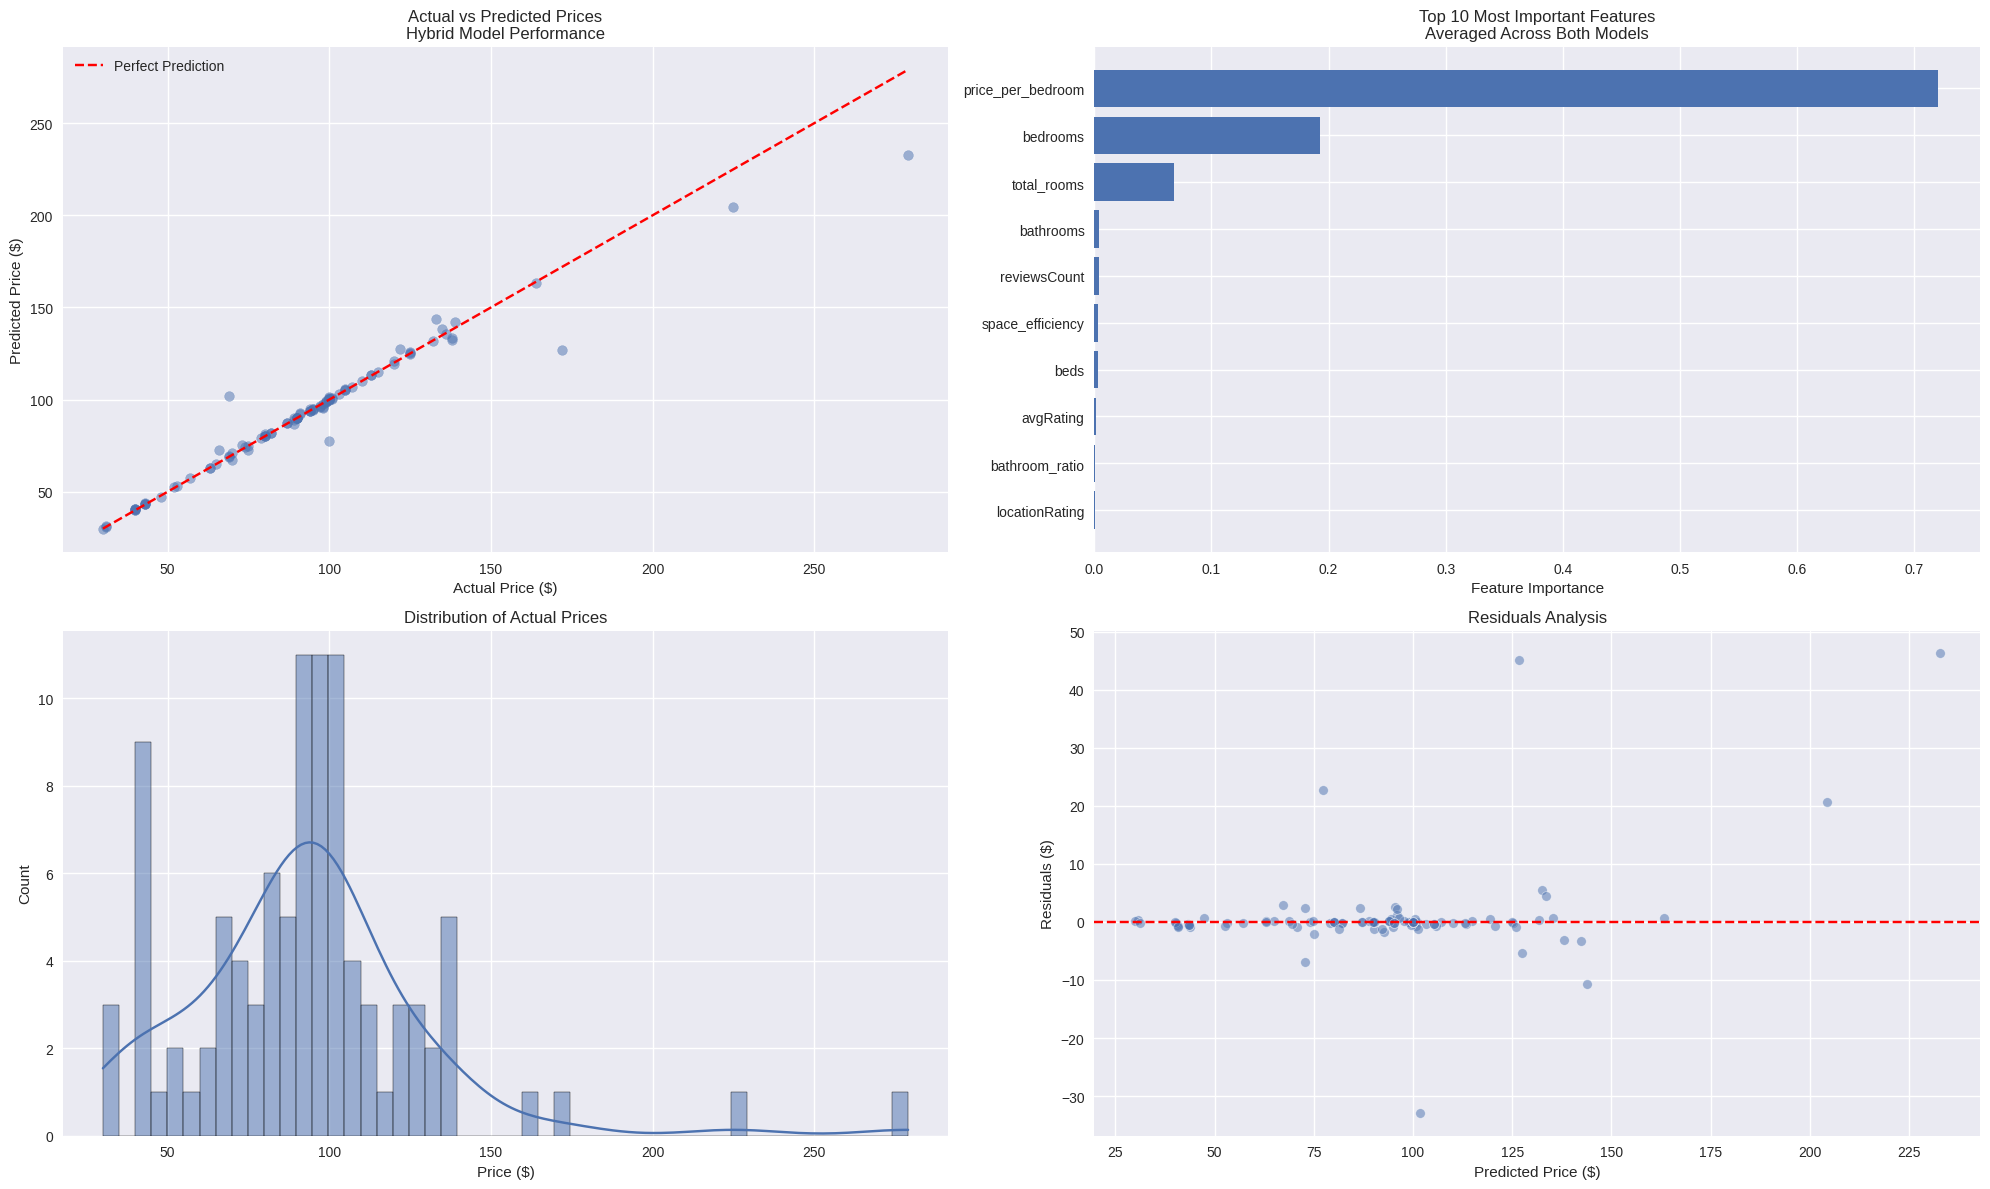

In [10]:
def main():
    """
    Main execution flow:
    - Loads and prepares data
    - Trains models
    - Generates visualizations
    - Displays results
    """
    df = load_data()
    X, y, preprocessor, numeric_features, categorical_features = prepare_data(df)
    results = train_hybrid_model(X, y, preprocessor)
    
    fig = plot_model_insights(results, preprocessor, numeric_features, categorical_features)
    report = create_model_report(results)
    print(report)

    analyze_listings_optimization(df, results)
    
    plt.show()
    plt.close()
    
    joblib.dump(results['gb_model'], '/kaggle/working/gradient_boosting_model.joblib')
    joblib.dump(results['rf_model'], '/kaggle/working/random_forest_model.joblib')

if __name__ == "__main__":
    pd.set_option('display.float_format', lambda x: '%.3f' % x if not pd.isna(x) else '')
    main()

## Airbnb Pricing Model Analysis
### Model Performance


* RMSE: $8.12 - Average prediction deviation
* MAE: $2.53 - Typical price variation
* R² Score: 0.952 - Explains 95.2% of price variance


### Practical Applications

### Price Optimization


* Set optimal price ranges within ±$2.53 of predicted value
* Confidence intervals for strategic pricing decisions
* Risk assessment tools for new listings



### Market Analysis


* Predict competitive pricing in different neighborhoods
* Seasonal pricing adjustments
* Analysis of property type impact on pricing



### Investment Planning


* ROI projections with 95.2% model accuracy
* Property value assessmentMarket opportunity identification


In [11]:
def display_price_optimizer(base_price=100):
    # Hardcoded metrics from model results
    rmse = 8.12
    mae = 2.53
    r2 = 0.952
    
    optimal_low = max(0, base_price - mae)
    optimal_high = base_price + mae
    conf_low = max(0, base_price - 1.96 * rmse)
    conf_high = base_price + 1.96 * rmse
    
    print(f"\n{'='*50}")
    print("Airbnb Price Optimizer")
    print(f"{'='*50}")
    print(f"\nModel Accuracy: {r2*100:.1f}% (R² Score)")
    print(f"\nFor Base Price: ${base_price:.2f}")
    print(f"\nRecommended Price Range:")
    print(f"${optimal_low:.2f} - ${optimal_high:.2f}")
    print(f"\n95% Confidence Interval:")
    print(f"${conf_low:.2f} - ${conf_high:.2f}")
    print(f"\nModel Metrics:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"{'='*50}")

# You can change the value here and experiment around with it:
display_price_optimizer(160)


Airbnb Price Optimizer

Model Accuracy: 95.2% (R² Score)

For Base Price: $160.00

Recommended Price Range:
$157.47 - $162.53

95% Confidence Interval:
$144.08 - $175.92

Model Metrics:
RMSE: $8.12
MAE: $2.53
